# Visualização de Clusters Fuzzy
Adaptação do código para plotar clusters fuzzy usando dados de throughput e utilização de PRB

In [16]:
# Importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import skfuzzy as fuzz
from sklearn.metrics import silhouette_score
import re


In [17]:
# Carregar o dataset
file_path = "data/df_agrupamentofuzzy_3.csv"
df = pd.read_csv(file_path)

# Verificar as primeiras linhas
print(df.head())
print(f"\nShape do dataset: {df.shape}")
print(f"\nColunas disponíveis: {list(df.columns)}")

               Data        Grupo Detentora  Vendor     eNodeB            Cell  \
0  2025-09-15 00:00  LMS_UFF_TNE       TIM  HUAWEI  4G-BRBRJ0  4G-BRBRJ0-07-A   
1  2025-09-15 00:00  LMS_UFF_TNE       TIM  HUAWEI  4G-BRBRJ0  4G-BRBRJ0-07-B   
2  2025-09-15 00:00  LMS_UFF_TNE       TIM  HUAWEI  4G-BRBRJ0  4G-BRBRJ0-07-C   
3  2025-09-15 00:00  LMS_UFF_TNE       TIM  HUAWEI  4G-BRBRJ0  4G-BRBRJ0-26-A   
4  2025-09-15 00:00  LMS_UFF_TNE       TIM  HUAWEI  4G-BRBRJ0  4G-BRBRJ0-26-B   

   TIM_PRB_AVAIL (Unid)  TIM_PRB_UTIL_MEAN_DL (%)  \
0                  50.0                     4.544   
1                  50.0                     5.398   
2                  50.0                     4.316   
3                 100.0                     0.935   
4                 100.0                     0.892   

   TIM_THROU_USER_PDCP_DL (Kbps)  TIM_USERS_RRC_CONN_MEAN_SUM_ALLOP (Unid)  \
0                    4180.205130                                     6.865   
1                    7406.687408      

In [18]:
colunas_pertinencia = [c for c in df.columns if re.match(r'pertinencia_cluster_\d+', c)]
colunas_cluster = [c for c in df.columns if c == 'cluster_fuzzy']
colunas_remover = colunas_pertinencia + colunas_cluster
colunas_sobraram = [c for c in df.columns if c not in colunas_remover]
colunas_features = [
    c for c in colunas_sobraram if df[c].dtype in ['int64', 'float64']
]

In [19]:
cluster_col = "cluster_fuzzy"

# Contar número de pessoas em cada cluster
cluster_counts = df[cluster_col].value_counts().sort_index()  # ordena por cluster
print("Número de pessoas em cada cluster:")
print(cluster_counts)

Número de pessoas em cada cluster:
cluster_fuzzy
0    6957
1    3534
2    9681
Name: count, dtype: int64


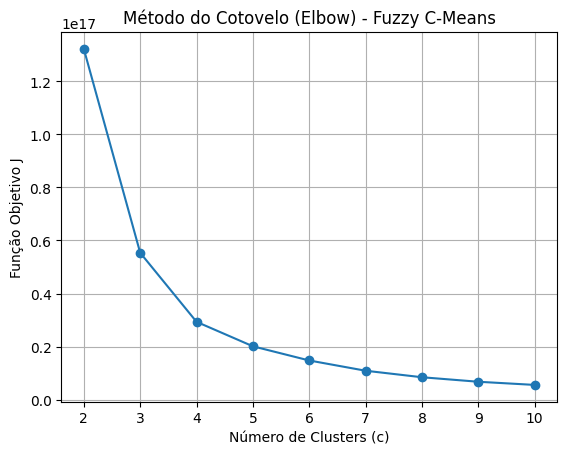

In [20]:
# Converter tudo para número e forçar erro caso algo não seja numérico
df_features = df[colunas_features].apply(pd.to_numeric, errors='raise')


X = df_features.to_numpy().T

clusters_range = range(2, 11)
objectives = []

for c in clusters_range:
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X, c=c, m=2, error=0.0001, maxiter=1000
    )

    objectives.append(jm[-1]) 

plt.plot(clusters_range, objectives, marker='o')
plt.xlabel("Número de Clusters (c)")
plt.ylabel("Função Objetivo J")
plt.title("Método do Cotovelo (Elbow) - Fuzzy C-Means")
plt.grid(True)
plt.show()

In [21]:
# Seleciona todas as colunas de pertinência automaticamente
col_pert = [c for c in df.columns if re.match(r'pertinencia_cluster_\d+', c)]
num_clusters = len(col_pert)

# Monta matriz de pertinências (n_amostras, n_clusters)
U = df[col_pert].to_numpy()

# Converte pertinências fuzzy para rótulos hard
labels = np.argmax(U, axis=1)

# Selecione as features originais (mesmo conjunto usado no FCM)
X = df[colunas_features].to_numpy()

# Calcula silhueta
sil = silhouette_score(X, labels)

print(f"Coeficiente de Silhueta = {sil:.4f}")


Coeficiente de Silhueta = 0.1310


In [22]:
print("Estatísticas por cluster:")

for cluster in sorted(df[cluster_col].unique()):
    subset = df[df[cluster_col] == cluster]

    print(f"\nCluster {cluster}:")
    print(f"  Quantidade de pontos: {len(subset)}")

    if len(subset) > 0:
        print(f"  Throughput médio: {subset[x_col].mean():.2f} Kbps")
        print(f"  Utilização PRB média: {subset[y_col].mean():.2f}%")
        print(f"  SETs presentes: {sorted(sets_unicos)}")
    else:
        print("  (Sem pontos neste cluster)")

Estatísticas por cluster:

Cluster 0:
  Quantidade de pontos: 6957


NameError: name 'x_col' is not defined

In [ ]:
# Gráfico adicional: distribuição dos SETs por cluster
plt.figure(figsize=(10, 6))

set_cluster_counts = df.groupby([cluster_col, 'set']).size().unstack(fill_value=0)
set_cluster_counts.plot(kind='bar', stacked=True, colormap='Set3')

plt.title('Distribuição dos SETs por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Quantidade de pontos')
plt.legend(title='SET', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

KeyError: 'set'

<Figure size 1000x600 with 0 Axes>